In [1]:
import glob
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

# 폴더 경로 지정
folder_path = r'C:\Users\pc\Desktop\CNN\CIC-AndMal2017'

In [2]:
benign_folder_path = r'C:\Users\pc\Desktop\CNN\CIC-AndMal2017\Benign'

# 'Benign' 클래스의 파일 경로 리스트 받아오기
benign_file_paths = glob.glob(benign_folder_path + '/*.csv')

# 'Benign' 클래스의 데이터프레임 초기화
benign_data = pd.DataFrame()

# 'Benign' 클래스의 모든 파일 로드
for file_path in benign_file_paths:
    data = pd.read_csv(file_path)
    benign_data = pd.concat([benign_data, data], ignore_index=True)

# 'Benign' 클래스에서 160,000개 무작위 샘플 추출
num_samples_benign = 160000
labels = []

if len(benign_data) > num_samples_benign:
    train_benign_subset = benign_data.sample(n=num_samples_benign, random_state=42)
else:
    train_benign_subset = benign_data.copy()

# Benign 데이터의 라벨을 labels 리스트에 추가
labels.extend(train_benign_subset[' Label'].tolist())

print("train_benign_subset의 샘플 개수:", len(train_benign_subset))

train_benign_subset의 샘플 개수: 160000


In [3]:
ransomware_folder_list = glob.glob(folder_path + '\\Ransomware\\*')
all_ransomware_data = pd.DataFrame()

for ransomware_folder_path in ransomware_folder_list:
    ransomware_file_paths = glob.glob(ransomware_folder_path + '/*.csv')
    
    # 각 랜섬웨어 클래스의 모든 파일 로드
    for file_path in ransomware_file_paths:
        data = pd.read_csv(file_path)
        all_ransomware_data = pd.concat([all_ransomware_data, data], ignore_index=True)

# 전체 랜섬웨어 데이터에서 160,000개 샘플 무작위로 추출
if len(all_ransomware_data) > 160000:
    train_ransomware_subset = all_ransomware_data.sample(n=160000, random_state=42, replace=False)
else:
    train_ransomware_subset = all_ransomware_data.copy()

# 랜섬웨어 데이터의 라벨을 labels 리스트에 추가
labels.extend(train_ransomware_subset[' Label'].tolist())

print("train_ransomware_subset의 샘플 개수:", len(train_ransomware_subset))

train_ransomware_subset의 샘플 개수: 160000


In [4]:
# 'Benign' 클래스와 랜섬웨어 클래스의 데이터프레임들을 합치기
train_dataset = pd.concat([train_benign_subset, train_ransomware_subset], ignore_index=True)

print("최종 train 데이터세트의 샘플 개수:", len(train_dataset))

최종 train 데이터세트의 샘플 개수: 320000


In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# 상관분석으로 선택된 특성들만 사용
selected_features = [
    ' ACK Flag Count',
    ' Active Max',
    ' Active Min',
    ' Active Std',
    ' Average Packet Size',
    ' Avg Bwd Segment Size',
    ' Bwd Header Length',
    ' Bwd Packet Length Mean',
    ' Bwd Packet Length Std',
    ' Bwd Packets/s',
    ' Flow Packets/s',
    ' Fwd Header Length',
    ' Fwd Packet Length Max',
    ' Idle Std',
    ' Max Packet Length',
    ' PSH Flag Count',
    ' Packet Length Mean',
    ' Packet Length Variance',
    ' Subflow Bwd Bytes',
    ' Subflow Bwd Packets',
    ' Subflow Fwd Bytes',
    ' Total Backward Packets',
    ' Total Fwd Packets',
    ' Total Length of Bwd Packets',
    ' act_data_pkt_fwd',
    ' min_seg_size_forward',
    'Active Mean',
    'Bwd Packet Length Max',
    'Flow Bytes/s',
    'Init_Win_bytes_forward',
    'Subflow Fwd Packets',
    'Total Length of Fwd Packets'
]

# 선택된 특성만 포함하는 데이터프레임 생성
X_selected = train_dataset[selected_features]

# 데이터 스케일링
scaler = MinMaxScaler()
scaler.fit(train_dataset[selected_features])  # 스케일러 학습
X_scaled = scaler.transform(train_dataset[selected_features])  # 훈련 데이터에 스케일러 적용

# 정규화된 특성들을 데이터프레임으로 변환
X_normalized = pd.DataFrame(X_scaled, columns=selected_features)

# 타깃 변수 데이터로 변환
y = np.array(labels)

# 결과 출력
print("정규화된 선택된 특성들의 데이터프레임:")
print(X_normalized.head())

정규화된 선택된 특성들의 데이터프레임:
    ACK Flag Count   Active Max   Active Min   Active Std  \
0              0.0     0.000000     0.000000          0.0   
1              1.0     0.000000     0.000000          0.0   
2              0.0     0.001415     0.001415          0.0   
3              0.0     0.000000     0.000000          0.0   
4              1.0     0.000000     0.000000          0.0   

    Average Packet Size   Avg Bwd Segment Size   Bwd Header Length  \
0              0.050957               0.070548            0.999152   
1              0.000000               0.000000            0.999152   
2              0.042511               0.025616            0.999152   
3              0.120576               0.089212            0.999152   
4              0.019426               0.000000            0.999152   

    Bwd Packet Length Mean   Bwd Packet Length Std   Bwd Packets/s  ...  \
0                 0.070548                0.000000    1.049131e-05  ...   
1                 0.000000              

In [6]:
X_padded = np.pad(X_normalized.values, ((0, 0), (0, 4)), mode='constant', constant_values=0)

# 선택된 특성을 6x6 크기의 2차원 행렬로 변환
num_rows = 6
num_columns = 6
X_final_reshaped = X_padded.reshape(-1, num_rows, num_columns)

# 결과 출력
print("6x6 크기의 2차원 행렬:")
for i in range(num_rows):
    print(X_final_reshaped[0][i])  # 첫 번째 샘플에 해당하는 2x3 행렬 출력

6x6 크기의 2차원 행렬:
[0.         0.         0.         0.         0.05095721 0.07054795]
[9.99151869e-01 7.05479452e-02 0.00000000e+00 1.04913080e-05
 1.04829678e-05 9.93128604e-01]
[0.00192384 0.         0.0050809  0.         0.04295206 0.00019831]
[4.79270392e-06 6.70690812e-05 4.00783933e-06 6.70690812e-05
 0.00000000e+00 4.79270392e-06]
[0.00000000e+00 8.91079304e-01 0.00000000e+00 7.90362185e-03
 1.12435149e-05 0.00000000e+00]
[0.00000000e+00 4.00783933e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [7]:
from PIL import Image
import os

# 이미지를 저장할 폴더를 생성합니다.
save_folder = r'C:\Users\pc\Desktop\CNN\Correlation\0.15_threshold\Train_Image\\'
os.makedirs(os.path.join(save_folder, "Benign"), exist_ok=True)
os.makedirs(os.path.join(save_folder, "Ransomware"), exist_ok=True)

# 이미지 확대 비율 설정
resize_factor = 10  # 10배 확대

# X_final_reshaped를 이미지로 변환하여 저장합니다.
num_samples = X_final_reshaped.shape[0]
for i in range(num_samples):
    # 1채널 16비트 PNG 이미지 생성
    image_data = X_final_reshaped[i]
    image_data = (image_data * 65535).astype('uint16')  # 16비트로 변환
    image = Image.fromarray(image_data, 'I;16')  # 16비트 단일 채널 이미지로 변환

    # 이미지 데이터 확대
    image_data = np.repeat(image_data, resize_factor, axis=0)  # 행 확대
    image_data = np.repeat(image_data, resize_factor, axis=1)  # 열 확대
    
    # 확대된 데이터를 다시 이미지로 변환
    image = Image.fromarray(image_data, 'I;16')  # 16비트 단일 채널 이미지로 변환
    
    # 이미지의 라벨에 따라서 저장 위치 및 파일명 설정
    if i < 160000:
        label = "Benign"
    else:
        label = "Ransomware"

    image_filename = f"image_{i}.png"
    image_filepath = os.path.join(save_folder, label, image_filename)

    # 해당 경로에 이미지가 이미 존재하는 경우 건너뛴다.
    if os.path.exists(image_filepath):
        continue

    image.save(image_filepath)

print("이미지 변환 및 저장이 완료되었습니다.")

이미지 변환 및 저장이 완료되었습니다.


In [8]:
import os
import cv2
import numpy as np

# 라벨 목록 및 해당 라벨에 대한 정수 값 지정
label_mapping = {
    "Benign": 0,
    "Ransomware": 1
}

# 이미지 데이터를 저장한 폴더 경로
image_folder = r'C:\Users\pc\Desktop\CNN\Correlation\0.15_threshold\Train_Image\\'
X_data = []
y_labels = []

# 모든 라벨마다 폴더를 순회합니다.
for label_str, label_int in label_mapping.items():
    folder_path = os.path.join(image_folder, label_str)  # 해당 라벨의 폴더 경로
    
    # 해당 폴더 내의 모든 이미지 파일을 순차적으로 처리
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        
        # 16-bit 이미지 로딩
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        
        if image is None:  # 이미지 로딩 실패
            print(f"Failed to load image at path: {image_path}")
            continue
        
        X_data.append(image)
        y_labels.append(label_int)

X_data = np.array(X_data, dtype=np.uint16)  # uint16 형태로 이미지 데이터 저장
y_labels = np.array(y_labels)

Label 0 has 160000 samples
Label 1 has 160000 samples
Showing images for label: Benign


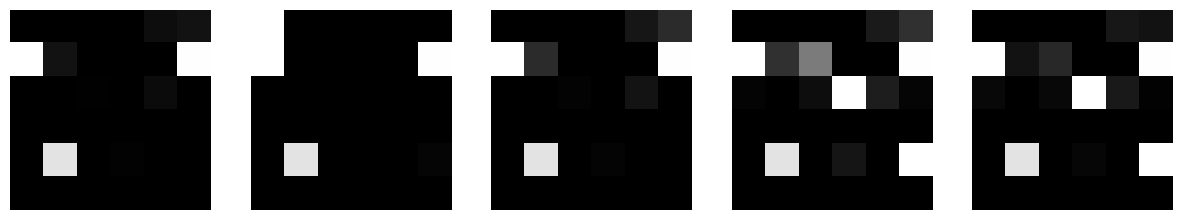

Showing images for label: Ransomware


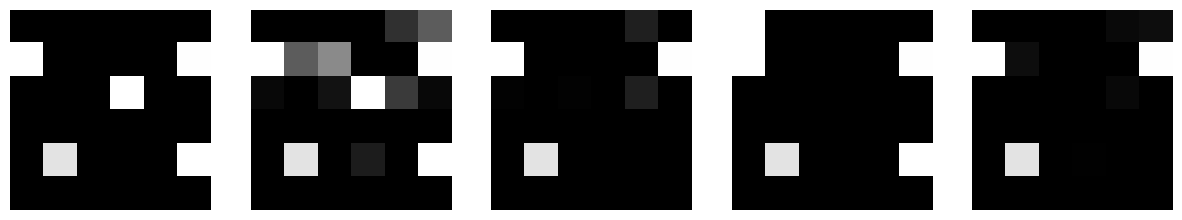

In [9]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# 라벨의 분포를 확인합니다.
label_counts = Counter(y_labels)
for label, count in label_counts.items():
    print(f"Label {label} has {count} samples")

# 라벨별로 이미지 몇 개를 시각화합니다.
num_images_to_show = 5  # 시각화할 이미지의 수를 설정합니다.

for label in label_mapping:
    print(f"Showing images for label: {label}")
    indices = [i for i, l in enumerate(y_labels) if l == label_mapping[label]]
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 3))
    for ax, idx in zip(axes, indices[:num_images_to_show]):
        ax.imshow(X_data[idx], cmap='gray')  # 16비트 이미지이므로 cmap='gray'를 사용합니다.
        ax.axis('off')
    plt.show()

In [10]:
# train_benign_subset에 포함되지 않은 데이터 선택
validation_data_candidate = benign_data.drop(train_benign_subset.index)

# 선택된 데이터 중에서 20,000개를 무작위로 선택
num_samples_validation = 20000
if len(validation_data_candidate) > num_samples_validation:
    validation_benign_subset = validation_data_candidate.sample(n=num_samples_validation, random_state=42)
else:
    validation_benign_subset = validation_data_candidate.copy()

print("validation_benign_subset의 샘플 개수:", len(validation_benign_subset))

validation_benign_subset의 샘플 개수: 20000


In [11]:
# train_ransomware_subset에 포함되지 않은 랜섬웨어 데이터 선택
validation_ransomware_candidate = all_ransomware_data.drop(train_ransomware_subset.index)

# 선택된 데이터 중에서 20,000개를 무작위로 선택
num_samples_validation_ransomware = 20000
if len(validation_ransomware_candidate) > num_samples_validation_ransomware:
    validation_ransomware_subset = validation_ransomware_candidate.sample(n=num_samples_validation_ransomware, random_state=42)
else:
    validation_ransomware_subset = validation_ransomware_candidate.copy()

print("validation_ransomware_subset의 샘플 개수:", len(validation_ransomware_subset))

validation_ransomware_subset의 샘플 개수: 20000


In [12]:
class_counts = validation_ransomware_subset[' Label'].value_counts()
print(class_counts)

RANSOMWARE_SVPENG         3114
RANSOMWARE_PORNDROID      2664
RANSOMWARE_KOLER          2542
RANSOMWARE_RANSOMBO       2248
RANSOMWARE_CHARGER        2219
RANSOMWARE_SIMPLOCKER     2086
RANSOMWARE_WANNALOCKER    1893
RANSOMWARE_LOCKERPIN      1495
RANSOMWARE_JISUT          1477
RANSOMWARE_PLETOR          262
Name:  Label, dtype: int64


In [13]:
# 'Benign' 클래스와 랜섬웨어 클래스의 데이터프레임들을 합치기
validation_dataset = pd.concat([validation_benign_subset, validation_ransomware_subset], ignore_index=True)

print("최종 validation 데이터세트의 샘플 개수:", len(validation_dataset))

최종 validation 데이터세트의 샘플 개수: 40000


In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# 상관분석으로 선택된 특성들만 사용
selected_features = [
    ' ACK Flag Count',
    ' Active Max',
    ' Active Min',
    ' Active Std',
    ' Average Packet Size',
    ' Avg Bwd Segment Size',
    ' Bwd Header Length',
    ' Bwd Packet Length Mean',
    ' Bwd Packet Length Std',
    ' Bwd Packets/s',
    ' Flow Packets/s',
    ' Fwd Header Length',
    ' Fwd Packet Length Max',
    ' Idle Std',
    ' Max Packet Length',
    ' PSH Flag Count',
    ' Packet Length Mean',
    ' Packet Length Variance',
    ' Subflow Bwd Bytes',
    ' Subflow Bwd Packets',
    ' Subflow Fwd Bytes',
    ' Total Backward Packets',
    ' Total Fwd Packets',
    ' Total Length of Bwd Packets',
    ' act_data_pkt_fwd',
    ' min_seg_size_forward',
    'Active Mean',
    'Bwd Packet Length Max',
    'Flow Bytes/s',
    'Init_Win_bytes_forward',
    'Subflow Fwd Packets',
    'Total Length of Fwd Packets'
]

# 선택된 특성만 포함하는 데이터프레임 생성
val_X_selected = validation_dataset[selected_features]

# 앞서 훈련 데이터에 대해 학습한 MinMaxScaler 인스턴스를 사용하여 검증 데이터를 변환
val_X_scaled = scaler.transform(val_X_selected)

# 정규화된 특성들을 데이터프레임으로 변환
val_X_normalized = pd.DataFrame(val_X_scaled, columns=selected_features)

# 타깃 변수 데이터로 변환
y = np.array(labels)

# 결과 출력
print("정규화된 선택된 특성들의 데이터프레임:")
print(val_X_normalized.head())

정규화된 선택된 특성들의 데이터프레임:
    ACK Flag Count   Active Max   Active Min   Active Std  \
0              0.0          0.0          0.0          0.0   
1              0.0          0.0          0.0          0.0   
2              1.0          0.0          0.0          0.0   
3              0.0          0.0          0.0          0.0   
4              0.0          0.0          0.0          0.0   

    Average Packet Size   Avg Bwd Segment Size   Bwd Header Length  \
0              0.240616               0.339937            0.999152   
1              0.000000               0.000000            0.999152   
2              0.000000               0.000000            0.999152   
3              0.096284               0.168493            0.999152   
4              0.000000               0.000000            0.999152   

    Bwd Packet Length Mean   Bwd Packet Length Std   Bwd Packets/s  ...  \
0                 0.339937                0.543822    5.774921e-06  ...   
1                 0.000000              

In [15]:
val_X_padded = np.pad(val_X_normalized.values, ((0, 0), (0, 4)), mode='constant', constant_values=0)

# 선택된 특성을 6x6 크기의 2차원 행렬로 변환
num_rows = 6
num_columns = 6
X_val_reshaped = val_X_padded.reshape(-1, num_rows, num_columns)

# 결과 출력
print("6x6 크기의 2차원 행렬:")
for i in range(num_rows):
    print(X_val_reshaped[0][i])  # 첫 번째 샘플에 해당하는 2x3 행렬 출력

6x6 크기의 2차원 행렬:
[0.         0.         0.         0.         0.24061562 0.33993678]
[9.99151871e-01 3.39936776e-01 5.43821623e-01 5.77492112e-06
 5.32235618e-06 9.93128606e-01]
[0.03413575 0.         0.06319061 1.         0.29205505 0.03621741]
[0.00030022 0.0008719  0.00039092 0.0008719  0.001485   0.00030022]
[8.91000891e-04 8.91079311e-01 0.00000000e+00 9.82965009e-02
 3.43846682e-05 1.00000000e+00]
[0.001485   0.00039092 0.         0.         0.         0.        ]


In [16]:
from PIL import Image
import os

# 이미지를 저장할 폴더를 생성합니다.
save_folder = r'C:\Users\pc\Desktop\CNN\Correlation\0.15_threshold\Validation_Image\\'
os.makedirs(os.path.join(save_folder, "Benign"), exist_ok=True)
os.makedirs(os.path.join(save_folder, "Ransomware"), exist_ok=True)

# 이미지 확대 비율 설정
resize_factor = 10  # 10배 확대

# X_final_reshaped를 이미지로 변환하여 저장합니다.
num_samples = X_val_reshaped.shape[0]
for i in range(num_samples):
    # 1채널 16비트 PNG 이미지 생성
    image_data = X_val_reshaped[i]
    image_data = (image_data * 65535).astype('uint16')  # 16비트로 변환
    image = Image.fromarray(image_data, 'I;16')  # 16비트 단일 채널 이미지로 변환

    # 이미지 데이터 확대
    image_data = np.repeat(image_data, resize_factor, axis=0)  # 행 확대
    image_data = np.repeat(image_data, resize_factor, axis=1)  # 열 확대
    
    # 확대된 데이터를 다시 이미지로 변환
    image = Image.fromarray(image_data, 'I;16')  # 16비트 단일 채널 이미지로 변환
    
    # 이미지의 라벨에 따라서 저장 위치 및 파일명 설정
    if i < 20000:
        label = "Benign"
    else:
        label = "Ransomware"

    image_filename = f"image_{i}.png"
    image_filepath = os.path.join(save_folder, label, image_filename)

    # 해당 경로에 이미지가 이미 존재하는 경우 건너뛴다.
    if os.path.exists(image_filepath):
        continue

    image.save(image_filepath)

print("이미지 변환 및 저장이 완료되었습니다.")

이미지 변환 및 저장이 완료되었습니다.


In [17]:
import os
import cv2
import numpy as np

# 라벨 목록 및 해당 라벨에 대한 정수 값 지정
label_mapping = {
    "Benign": 0,
    "Ransomware": 1
}

# 이미지 데이터를 저장한 폴더 경로
image_folder = r'C:\Users\pc\Desktop\CNN\Correlation\0.15_threshold\Validation_Image\\'  # Modified path to "Validation_Image"

X_val_data = []  # Changed variable name to X_val_data for clarity
y_val_labels = []  # Changed variable name to y_val_labels for clarity

# 모든 라벨마다 폴더를 순회합니다.
for label_str, label_int in label_mapping.items():
    folder_path = os.path.join(image_folder, label_str)  # 해당 라벨의 폴더 경로
    
    # 해당 폴더 내의 모든 이미지 파일을 순차적으로 처리
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        
        # 16-bit 이미지 로딩
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        
        if image is None:  # 이미지 로딩 실패
            print(f"Failed to load image at path: {image_path}")
            continue
        
        X_val_data.append(image)  # Changed variable name
        y_val_labels.append(label_int)  # Changed variable name

X_val_data = np.array(X_val_data, dtype=np.uint16)  # uint16 형태로 이미지 데이터 저장, changed variable name
y_val_labels = np.array(y_val_labels)  # Changed variable name

Label 0 has 160000 samples
Label 1 has 160000 samples
Showing images for label: Benign


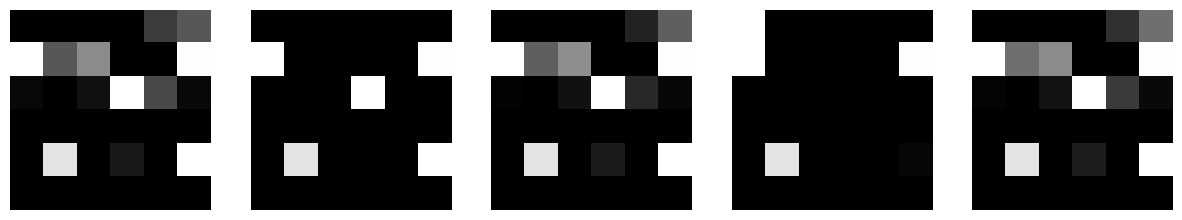

Showing images for label: Ransomware


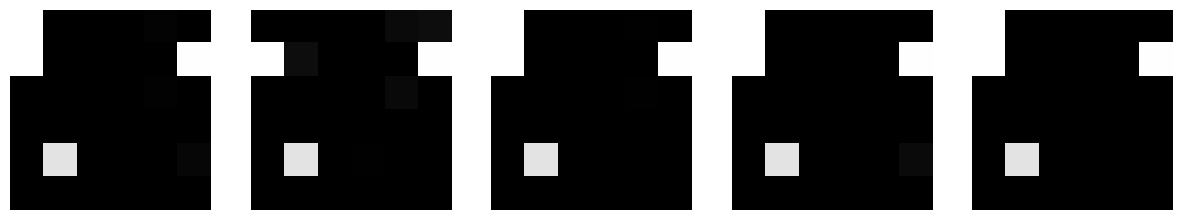

In [18]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# 라벨의 분포를 확인합니다.
label_counts = Counter(y_labels)
for label, count in label_counts.items():
    print(f"Label {label} has {count} samples")

# 라벨별로 이미지 몇 개를 시각화합니다.
num_images_to_show = 5  # 시각화할 이미지의 수를 설정합니다.

for label in label_mapping:
    print(f"Showing images for label: {label}")
    indices = [i for i, l in enumerate(y_val_labels) if l == label_mapping[label]]
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 3))
    for ax, idx in zip(axes, indices[:num_images_to_show]):
        ax.imshow(X_val_data[idx], cmap='gray')  # 16비트 이미지이므로 cmap='gray'를 사용합니다.
        ax.axis('off')
    plt.show()

In [19]:
# train_benign_subset 및 validation_benign_subset에 포함되지 않은 데이터 선택
test_data_candidate = benign_data.drop(train_benign_subset.index).drop(validation_benign_subset.index)

# 선택된 데이터 중에서 20,000개를 무작위로 선택
num_samples_test = 20000
if len(test_data_candidate) > num_samples_test:
    test_benign_subset = test_data_candidate.sample(n=num_samples_test, random_state=42)
else:
    test_benign_subset = test_data_candidate.copy()

print("test_benign_subset의 샘플 개수:", len(test_benign_subset))

test_benign_subset의 샘플 개수: 20000


In [20]:
# validation_ransomware_subset에 포함되지 않은 랜섬웨어 데이터 선택
test_ransomware_candidate = validation_ransomware_candidate.drop(validation_ransomware_subset.index)

# 선택된 데이터 중에서 20,000개를 무작위로 선택
num_samples_test_ransomware = 20000
if len(test_ransomware_candidate) > num_samples_test_ransomware:
    test_ransomware_subset = test_ransomware_candidate.sample(n=num_samples_test_ransomware, random_state=42)
else:
    test_ransomware_subset = test_ransomware_candidate.copy()

print("test_ransomware_subset의 샘플 개수:", len(test_ransomware_subset))

test_ransomware_subset의 샘플 개수: 20000


In [21]:
# 'Benign' 클래스와 랜섬웨어 클래스의 데이터프레임들을 합치기
test_dataset = pd.concat([test_benign_subset, test_ransomware_subset], ignore_index=True)

print("최종 test 데이터세트의 샘플 개수:", len(test_dataset))

최종 test 데이터세트의 샘플 개수: 40000


In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# 상관분석으로 선택된 특성들만 사용
selected_features = [
    ' ACK Flag Count',
    ' Active Max',
    ' Active Min',
    ' Active Std',
    ' Average Packet Size',
    ' Avg Bwd Segment Size',
    ' Bwd Header Length',
    ' Bwd Packet Length Mean',
    ' Bwd Packet Length Std',
    ' Bwd Packets/s',
    ' Flow Packets/s',
    ' Fwd Header Length',
    ' Fwd Packet Length Max',
    ' Idle Std',
    ' Max Packet Length',
    ' PSH Flag Count',
    ' Packet Length Mean',
    ' Packet Length Variance',
    ' Subflow Bwd Bytes',
    ' Subflow Bwd Packets',
    ' Subflow Fwd Bytes',
    ' Total Backward Packets',
    ' Total Fwd Packets',
    ' Total Length of Bwd Packets',
    ' act_data_pkt_fwd',
    ' min_seg_size_forward',
    'Active Mean',
    'Bwd Packet Length Max',
    'Flow Bytes/s',
    'Init_Win_bytes_forward',
    'Subflow Fwd Packets',
    'Total Length of Fwd Packets'
]

# 선택된 특성만 포함하는 데이터프레임 생성
test_X_selected = test_dataset[selected_features]

# 앞서 훈련 데이터에 대해 학습한 MinMaxScaler 인스턴스를 사용하여 테스트 데이터를 변환
test_X_scaled = scaler.transform(test_X_selected)

# 정규화된 특성들을 데이터프레임으로 변환
test_X_normalized = pd.DataFrame(test_X_scaled, columns=selected_features)

# 타깃 변수 데이터로 변환
y = np.array(labels)

# 결과 출력
print("정규화된 선택된 특성들의 데이터프레임:")
print(test_X_normalized.head())

정규화된 선택된 특성들의 데이터프레임:
    ACK Flag Count   Active Max   Active Min   Active Std  \
0              0.0          0.0          0.0          0.0   
1              0.0          0.0          0.0          0.0   
2              0.0          0.0          0.0          0.0   
3              0.0          0.0          0.0          0.0   
4              0.0          0.0          0.0          0.0   

    Average Packet Size   Avg Bwd Segment Size   Bwd Header Length  \
0              0.196767               0.341324            0.999152   
1              0.169388               0.434075            0.999152   
2              0.089527               0.165753            0.999152   
3              0.331300               0.394178            0.999152   
4              0.000000               0.000000            0.999152   

    Bwd Packet Length Mean   Bwd Packet Length Std   Bwd Packets/s  ...  \
0                 0.341324                0.526239    4.671853e-06  ...   
1                 0.434075              

In [25]:
test_X_padded = np.pad(test_X_normalized.values, ((0, 0), (0, 4)), mode='constant', constant_values=0)

# 선택된 특성을 6x6 크기의 2차원 행렬로 변환
num_rows = 6
num_columns = 6
X_test_reshaped = test_X_padded.reshape(-1, num_rows, num_columns)

# 결과 출력
print("6x6 크기의 2차원 행렬:")
for i in range(num_rows):
    print(X_test_reshaped[0][i])  # 첫 번째 샘플에 해당하는 2x3 행렬 출력

6x6 크기의 2차원 행렬:
[0.         0.         0.         0.         0.19676708 0.3413242 ]
[9.99151871e-01 3.41324201e-01 5.26239224e-01 4.67185294e-06
 4.66351271e-06 9.93128606e-01]
[0.05880032 0.         0.07142857 1.         0.23883246 0.03838331]
[0.00027826 0.00080483 0.00024736 0.00080483 0.0016335  0.00027826]
[5.94000594e-04 8.91079311e-01 0.00000000e+00 1.11111111e-01
 2.46432897e-05 1.00000000e+00]
[0.0016335  0.00024736 0.         0.         0.         0.        ]


In [26]:
from PIL import Image
import os

# 이미지를 저장할 폴더를 생성합니다.
save_folder = r'C:\Users\pc\Desktop\CNN\Correlation\0.15_threshold\Test_Image\\'
os.makedirs(os.path.join(save_folder, "Benign"), exist_ok=True)
os.makedirs(os.path.join(save_folder, "Ransomware"), exist_ok=True)

# 이미지 확대 비율 설정
resize_factor = 10  # 10배 확대

# X_final_reshaped를 이미지로 변환하여 저장합니다.
num_samples = X_test_reshaped.shape[0]
for i in range(num_samples):
    # 1채널 16비트 PNG 이미지 생성
    image_data = X_test_reshaped[i]
    image_data = (image_data * 65535).astype('uint16')  # 16비트로 변환
    image = Image.fromarray(image_data, 'I;16')  # 16비트 단일 채널 이미지로 변환

    # 이미지 데이터 확대
    image_data = np.repeat(image_data, resize_factor, axis=0)  # 행 확대
    image_data = np.repeat(image_data, resize_factor, axis=1)  # 열 확대
    
    # 확대된 데이터를 다시 이미지로 변환
    image = Image.fromarray(image_data, 'I;16')  # 16비트 단일 채널 이미지로 변환
    
    # 이미지의 라벨에 따라서 저장 위치 및 파일명 설정
    if i < 20000:
        label = "Benign"
    else:
        label = "Ransomware"

    image_filename = f"image_{i}.png"
    image_filepath = os.path.join(save_folder, label, image_filename)

    # 해당 경로에 이미지가 이미 존재하는 경우 건너뛴다.
    if os.path.exists(image_filepath):
        continue

    image.save(image_filepath)

print("이미지 변환 및 저장이 완료되었습니다.")

이미지 변환 및 저장이 완료되었습니다.


In [27]:
import os
import cv2
import numpy as np

# 라벨 목록 및 해당 라벨에 대한 정수 값 지정
label_mapping = {
    "Benign": 0,
    "Ransomware": 1
}

# 이미지 데이터를 저장한 폴더 경로
image_folder = r'C:\Users\pc\Desktop\CNN\Correlation\0.15_threshold\Test_Image\\'  # Modified path to "Test_Image"

X_test_data = []  # Changed variable name to X_test_data for clarity
y_test_labels = []  # Changed variable name to y_test_labels for clarity

# 모든 라벨마다 폴더를 순회합니다.
for label_str, label_int in label_mapping.items():
    folder_path = os.path.join(image_folder, label_str)  # 해당 라벨의 폴더 경로
    
    # 해당 폴더 내의 모든 이미지 파일을 순차적으로 처리
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        
        # 16-bit 이미지 로딩
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        
        if image is None:  # 이미지 로딩 실패
            print(f"Failed to load image at path: {image_path}")
            continue
        
        X_test_data.append(image)  # Changed variable name
        y_test_labels.append(label_int)  # Changed variable name

X_test_data = np.array(X_test_data, dtype=np.uint16)  # uint16 형태로 이미지 데이터 저장, changed variable name
y_test_labels = np.array(y_test_labels)  # Changed variable name